In [31]:
import os
import pickle
import numpy as np
import numpy.linalg as la
import PIL.Image
import PIL.ImageSequence
import dnnlib
import dnnlib.tflib as tflib
import IPython.display
import moviepy
import moviepy.editor
import math
import glob
import csv
from functools import partial

import tensorflow as tf

import keras
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.linear_model import LinearRegression, Lasso

import colorsys

In [2]:
##
# Load network snapshot
##

#input_sg_name = "2019-02-09-stylegan-danbooru2017-faces-network-snapshot-007841.pkl"
input_sg_name = "2019-02-18-stylegan-faces-network-02041-011095.pkl"

tflib.init_tf()

# Load pre-trained network.
with open(input_sg_name, 'rb') as f:
    # _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
    # _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
    # Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.    
    _G, _D, Gs = pickle.load(f)
        
# Print network details.
Gs.print_layers()


Gs                            Params    OutputShape         WeightShape     
---                           ---       ---                 ---             
latents_in                    -         (?, 512)            -               
labels_in                     -         (?, 0)              -               
lod                           -         ()                  -               
dlatent_avg                   -         (512,)              -               
G_mapping/latents_in          -         (?, 512)            -               
G_mapping/labels_in           -         (?, 0)              -               
G_mapping/PixelNorm           -         (?, 512)            -               
G_mapping/Dense0              262656    (?, 512)            (512, 512)      
G_mapping/Dense1              262656    (?, 512)            (512, 512)      
G_mapping/Dense2              262656    (?, 512)            (512, 512)      
G_mapping/Dense3              262656    (?, 512)            (512, 512)     

In [3]:
##
# Build things on top for encoding
# Based on https://github.com/Puzer/stylegan
##
def create_stub(name, batch_size):
    return tf.constant(0, dtype='float32', shape=(batch_size, 0))

def create_variable_for_generator(name, batch_size):
    return tf.get_variable('learnable_dlatents',
                           shape=(batch_size, 16, 512),
                           dtype='float32',
                           initializer=tf.initializers.zeros())

initial_dlatents = np.zeros((1, 16, 512))
Gs.components.synthesis.run(
    initial_dlatents,
    randomize_noise = True, # Turns out this should not be off ever for trying to lean dlatents, who knew
    minibatch_size = 1,
    custom_inputs = [
        partial(create_variable_for_generator, batch_size=1),
        partial(create_stub, batch_size = 1)],
    structure = 'fixed'
)

# Generation-from-disentangled-latents part
dlatent_variable = next(v for v in tf.global_variables() if 'learnable_dlatents' in v.name)
generator_output = tf.get_default_graph().get_tensor_by_name('G_synthesis_1/_Run/G_synthesis/images_out:0')
generated_image = tflib.convert_images_to_uint8(generator_output, nchw_to_nhwc=True, uint8_cast=False)
generated_image_uint8 = tf.saturate_cast(generated_image, tf.uint8)

# Loss part
vgg16 = VGG16(include_top=False, input_shape=(512, 512, 3))
perceptual_model = keras.Model(vgg16.input, vgg16.layers[9].output)
generated_img_features = perceptual_model(preprocess_input(generated_image, mode="tf"))
ref_img = tf.get_variable(
    'ref_img', 
    shape = generated_image.shape,
    dtype = 'float32', 
    initializer = tf.zeros_initializer()
)
ref_img_features = tf.get_variable(
    'ref_img_features', 
    shape = generated_img_features.shape,
    dtype = 'float32', 
    initializer = tf.zeros_initializer()
)
tf.get_default_session().run([ref_img.initializer, ref_img_features.initializer])
basic_loss = tf.losses.mean_squared_error(ref_img, generated_image)
perceptual_loss = tf.losses.mean_squared_error(ref_img_features, generated_img_features)

In [16]:
# Gradient descend in latent space to something that is similar to the input image
def encode_image(image, iterations = 1024, learning_rate = 0.1, reset_dlatents = True):
    # Get session
    sess = tf.get_default_session()
    
    # Gradient descent initial state
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    optimizer = tf.train.AdadeltaOptimizer(learning_rate = learning_rate)
    min_op = optimizer.minimize(perceptual_loss, var_list=[[dlatent_variable]])
    if reset_dlatents == True:
        sess.run(tf.assign(dlatent_variable, initial_dlatents))
    
    # Generate and set reference image features
    ref_image_data = np.array(list(map(lambda x: (x.astype("float32")), [image])))
    image_features = perceptual_model.predict_on_batch(preprocess_input(ref_image_data, mode="tf"))  
    sess.run(tf.assign(ref_img_features, image_features))
    
    # Run
    for i in range(iterations):
        _, loss = sess.run([min_op, perceptual_loss])
        """
        if i % 100 == 0:
            print("i: {}, l: {}".format(i, loss))
        """
    
    # Generate image that actually goes with these dlatents for quick testing
    dlatents = sess.run(dlatent_variable)[0]
    generated_image = generate_images_from_dlatents(dlatents)
    
    return dlatents, generated_image

# Same as above but start with given dlatents and use plain MSE loss instead of vgg16
def finetune_image(dlatents, image, iterations = 32, learning_rate = 0.0001):
    # Get session and assign initial dlatents
    sess = tf.get_default_session()
    sess.run(tf.assign(dlatent_variable, np.array([dlatents])))
    
    # Set reference image
    ref_image_data = np.array(list(map(lambda x: (x.astype("float64")), [image])))
    sess.run(tf.assign(ref_img, ref_image_data))    
    
    # Gradient descent
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    min_op = optimizer.minimize(basic_loss, var_list=[[dlatent_variable]])
    
    for i in range(iterations):
        _, loss = sess.run([min_op, basic_loss])
        """
        if i % 100 == 0:
            print("i: {}, l: {}".format(i, loss))
        """
    # Generate image that actually goes with these latents for quick testing
    dlatents = sess.run(dlatent_variable)[0]
    generated_image = generate_images_from_dlatents(dlatents)
    
    return dlatents, generated_image

# Generate image with disentangled latents as input
def generate_images_from_dlatents(dlatents):
    tf.get_default_session().run(tf.assign(dlatent_variable, np.array([dlatents])))
    return tf.get_default_session().run(generated_image_uint8)[0]

# Sequence of learning steps while reducing lr followed by finetune
def encode_and_tune(image, iters_per_step = 1024):
    dlatents_gen, image_gen = encode_image(image, iterations = iters_per_step, learning_rate = 100.0)
    dlatents_gen2, image_gen2 = encode_image(image, iterations = iters_per_step, learning_rate = 10.0, reset_dlatents = False)
    dlatents_gen3, image_gen3 = encode_image(image, iterations = iters_per_step, learning_rate = 1.0, reset_dlatents = False)
    dlatents_gen4, image_gen4 = encode_image(image, iterations = iters_per_step, learning_rate = 0.1, reset_dlatents = False)
    dlatents_gen5, image_gen5 = encode_image(image, iterations = iters_per_step, learning_rate = 0.01, reset_dlatents = False)
    dlatents_gen6, image_gen6 = finetune_image(dlatents_gen5, image, iterations = 64)
    return dlatents_gen6, image_gen6

In [5]:
##
# 1. Just generate a neat interpolation video
##
# Pick latent vectors
#rnd = np.random.RandomState(5)
rnd = np.random
latents_a = rnd.randn(1, Gs.input_shape[1])
latents_b = rnd.randn(1, Gs.input_shape[1])
latents_c = rnd.randn(1, Gs.input_shape[1])

if os.path.exists("latents.npy"):
    latents_a, latents_b, latents_c = np.load("latents.npy")
np.save("latents.npy", np.array([latents_a, latents_b, latents_c]))

In [6]:
# "Ellipse around a point but probably a circle since it's 512 dimensions"
def circ_generator(latents_interpolate):
    radius = 40.0

    latents_axis_x = (latents_a - latents_b).flatten() / la.norm(latents_a - latents_b)
    latents_axis_y = (latents_a - latents_c).flatten() / la.norm(latents_a - latents_c)

    latents_x = math.sin(math.pi * 2.0 * latents_interpolate) * radius
    latents_y = math.cos(math.pi * 2.0 * latents_interpolate) * radius

    latents = latents_a + latents_x * latents_axis_x + latents_y * latents_axis_y
    return latents

# Generate images from a list of latents
def generate_from_latents(latent_list):
    array_list = []
    image_list = []
    for latents in latent_list:
        # Generate image.
        fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
        images = Gs.run(latents, None, truncation_psi=0.5, randomize_noise=False, output_transform=fmt)
        array_list.append(images[0])
        image_list.append(PIL.Image.fromarray(images[0], 'RGB'))
        
    return array_list, image_list

def mse(x, y):
    return (np.square(x - y)).mean()

# Generate from a latent generator, keeping MSE between frames constant
def generate_from_generator_adaptive(gen_func):
    max_step = 1.0
    current_pos = 0.0
    
    change_min = 10.0
    change_max = 11.0
    
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    
    current_latent = gen_func(current_pos)
    current_image = Gs.run(current_latent, None, truncation_psi=0.5, randomize_noise=False, output_transform=fmt)[0]
    array_list = []
    
    while(current_pos < 1.0):
        array_list.append(current_image)
        
        lower = current_pos
        upper = current_pos + max_step
        current_pos = (upper + lower) / 2.0
        
        current_latent = gen_func(current_pos)
        current_image = images = Gs.run(current_latent, None, truncation_psi=0.5, randomize_noise=False, output_transform=fmt)[0]
        current_mse = mse(array_list[-1], current_image)
        
        while current_mse < change_min or current_mse > change_max:
            if current_mse < change_min:
                lower = current_pos
                current_pos = (upper + lower) / 2.0
            
            if current_mse > change_max:
                upper = current_pos
                current_pos = (upper + lower) / 2.0
                
            
            current_latent = gen_func(current_pos)
            current_image = images = Gs.run(current_latent, None, truncation_psi=0.5, randomize_noise=False, output_transform=fmt)[0]
            current_mse = mse(array_list[-1], current_image)
        print(current_pos, current_mse)
        
    return array_list

In [ ]:
#array_list, _ = generate_from_latents(latent_list)
array_list = generate_from_generator_adaptive(circ_generator)
clip = moviepy.editor.ImageSequenceClip(array_list, fps=60)
clip.ipython_display()
#clip.write_videofile("out.mp4")

In [20]:
##
# 2. Encoding
##

# Load and cut and scale a bunch of data from the animefaces dataset
img_files = []
hair_cols = []
eye_cols = []
for in_dir in glob.glob("../../stylegan/animeface-character-dataset/thumb/*"):
    if not os.path.exists(in_dir + "/color.csv"):
        continue
    with open(in_dir + "/color.csv", 'r') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            img_files.append(in_dir + "/" + row[0])
            hair_cols.append([row[1], row[2], row[3]])
            eye_cols.append([row[4], row[5], row[6]])
img_files = img_files[1::300]
hair_cols = hair_cols[1::300]
eye_cols = eye_cols[1::300]
print(len(img_files))

image_arrays = []
for img_file in img_files:
    image_data = PIL.Image.open(img_file)
    image_size = min(image_data.width, image_data.height)
    image_data = image_data.crop((0, 0, image_size, image_size))
    image_data = image_data.resize((512, 512), PIL.Image.BILINEAR)
    image_array = np.array(image_data)
    image_arrays.append(image_array)

48


In [21]:
dlatents_gen, image_gen = encode_and_tune(image_arrays[0])
im = PIL.Image.new('RGB', (1024, 512))
im.paste(PIL.Image.fromarray(image_arrays[0], 'RGB'), (0, 0))
im.paste(PIL.Image.fromarray(image_gen, 'RGB'), (512, 0))
im

KeyboardInterrupt: 

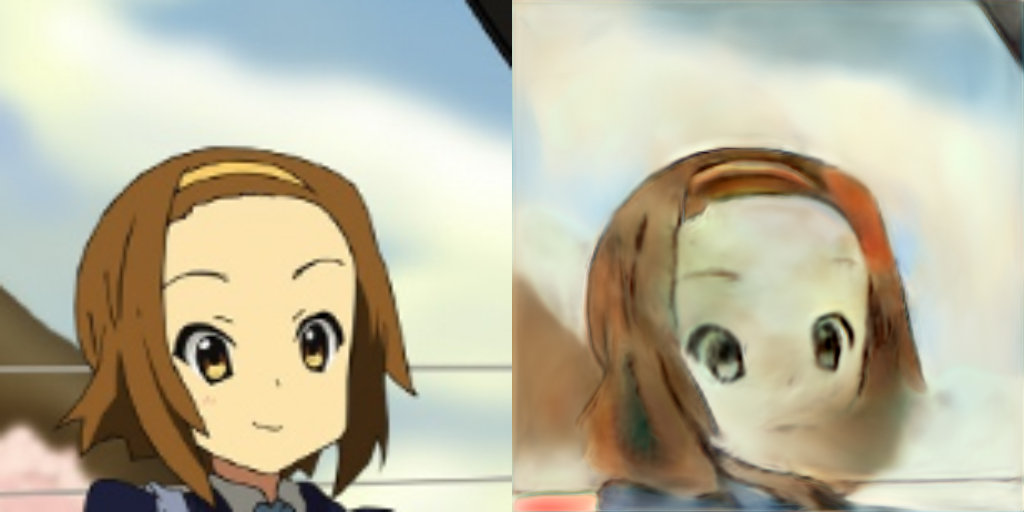

Processing image 10


KeyboardInterrupt: 

In [22]:
generated_dlatents = []
generated_images = []
for idx, image_array in enumerate(image_arrays):
    # Unfortunately very slow. 
    print("Processing image {}".format(idx))
    dlatents_gen, image_gen = encode_and_tune(image_array, iters_per_step = 512)
    generated_dlatents.append(dlatents_gen)
    generated_images.append(image_gen)
    
    IPython.display.clear_output()
    im = PIL.Image.new('RGB', (1024, 512))
    im.paste(PIL.Image.fromarray(image_array, 'RGB'), (0, 0))
    im.paste(PIL.Image.fromarray(image_gen, 'RGB'), (512, 0))
    IPython.display.display(im)

In [23]:
np.save("generated_dlatents_10_300step.npy", generated_dlatents)

In [95]:
def find_direction(dlatents, targets):
    clf = LinearRegression().fit(dlatents, targets)
    return clf.coef_.reshape((16, 512))
     
dlatents_for_regression = []
hair_brightness = []
hair_saturation = []
hair_hue = []
hair_r = []
hair_g = []
hair_b = []
for dlatents, hair_color in zip(generated_dlatents, hair_cols):
    hair_h, hair_s, hair_v = colorsys.rgb_to_hsv(*list(map(lambda x: float(x) / 256.0, hair_color)))
    dlatents_for_regression.append(dlatents.reshape((16*512)))
    hair_brightness.append(np.array([hair_v]))
    hair_saturation.append(np.array([hair_s]))
    hair_hue.append(np.array([hair_h]))
    hair_r.append(float(hair_color[0]) / 256.0)
    hair_g.append(float(hair_color[0]) / 256.0)
    hair_b.append(float(hair_color[0]) / 256.0)
dlatents_for_regression = np.array(dlatents_for_regression)
hair_brightness = np.array(hair_brightness)
hair_saturation = np.array(hair_saturation)

brightness_dir = find_direction(dlatents_for_regression, hair_brightness)
saturation_dir = find_direction(dlatents_for_regression, hair_saturation)
hue_dir = find_direction(dlatents_for_regression, hair_hue)
r_dir = find_direction(dlatents_for_regression, hair_hue)
g_dir = find_direction(dlatents_for_regression, hair_hue)
b_dir = find_direction(dlatents_for_regression, hair_hue)
print(np.sum(np.abs(brightness_dir)))
print(np.sum(np.abs(saturation_dir)))
print(np.sum(np.abs(hue_dir)))

0.90359217
0.40774015
1.754661


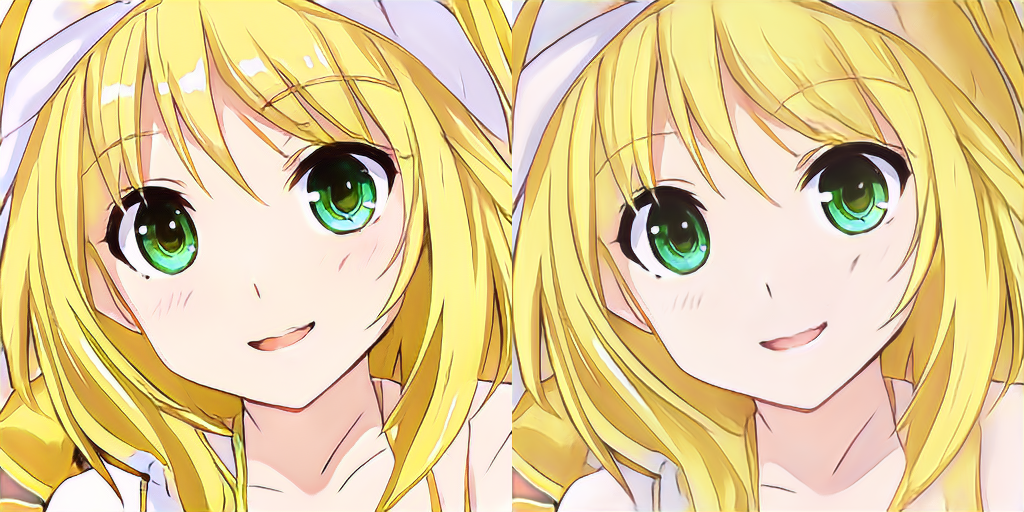

In [43]:
# Re-encode a generated image 
# (mind: this is pointless for actual usage, if you're generating you can just 
# take the latents from the generation step). it's a nice check for encoding, though.
generated_ref = generate_from_latents([latents_a])[0][0]
dlatents_gen, image_gen = encode_and_tune(generated_ref, iters_per_step = 1024)
im = PIL.Image.new('RGB', (1024, 512))
im.paste(PIL.Image.fromarray(generated_ref, 'RGB'), (0, 0))
im.paste(PIL.Image.fromarray(image_gen, 'RGB'), (512, 0))
im

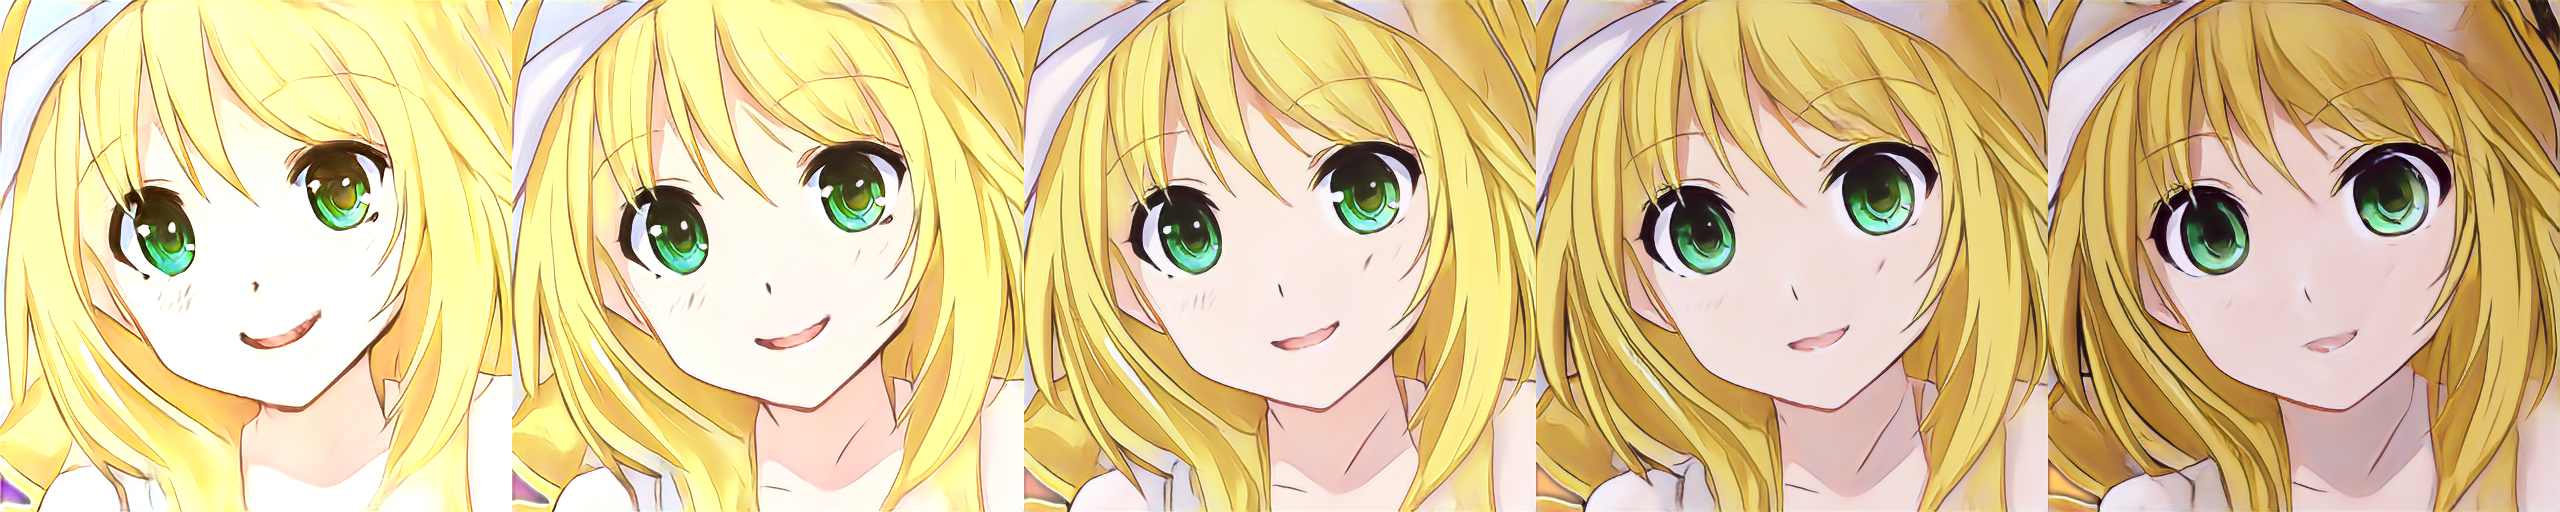

In [114]:
# Modify it
im = PIL.Image.new('RGB', (512 * 5, 512))
for i in range(-2, 3):
    dlatents_mod_image = generate_images_from_dlatents(dlatents_gen - brightness_dir * (1000.0 * i))
    im.paste(PIL.Image.fromarray(dlatents_mod_image, 'RGB'), (512 * (i + 2), 0))
im